In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
import torch
from torch import nn

In [5]:
import numpy as np

In [6]:
import torchvision as tv

In [7]:
import pandas as pd
import numpy as np

In [8]:
import time

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
print(device)

cuda


In [11]:
BATCH_SIZE=256

In [12]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [13]:
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [14]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

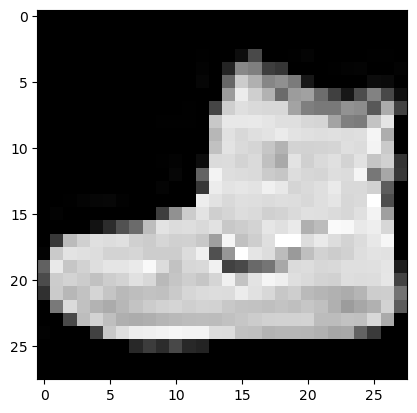

In [15]:
plt.imshow(train_dataset[0][0].numpy().reshape(28,28), cmap='gray');

## Модель

In [17]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=1),

    nn.Conv2d(6, 32, kernel_size=3),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    
    nn.Conv2d(64, 128, kernel_size=5),
    nn.Tanh(),
    
    nn.Flatten(),
    
    nn.Linear(128, 64),
    #torch.nn.Dropout(p=0.5), 
    nn.Tanh(),
    
    nn.Linear(64, 10)
)

model = model.to(device)
from torchsummary import summary

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 27, 27]               0
            Conv2d-4           [-1, 32, 25, 25]           1,760
              Tanh-5           [-1, 32, 25, 25]               0
         AvgPool2d-6           [-1, 32, 12, 12]               0
            Conv2d-7           [-1, 64, 10, 10]          18,496
              Tanh-8           [-1, 64, 10, 10]               0
         AvgPool2d-9             [-1, 64, 5, 5]               0
           Conv2d-10            [-1, 128, 1, 1]         204,928
             Tanh-11            [-1, 128, 1, 1]               0
          Flatten-12                  [-1, 128]               0
           Linear-13                   [-1, 64]           8,256
             Tanh-14                   

In [18]:
lr, num_epochs = 0.5, 95

In [19]:
def train(net, train_iter, test_iter, optimizer, num_epochs, device):
    loss = nn.CrossEntropyLoss()

    train_acc_graph = torch.zeros(num_epochs,2)
    test_acc_graph = torch.zeros(num_epochs,2)
    ep = 0
        
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()        
    
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
    
        test_acc = evaluate_accuracy(test_iter, net, device)
                
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
        
        train_acc_graph[ep, 0] = ep
        train_acc_graph[ep, 1] = train_acc_sum / n
        test_acc_graph[ep, 0] = ep
        test_acc_graph[ep, 1] = test_acc
        ep += 1
        
    plt.figure(figsize=(10, 5))

    plt.subplot(1,2,1)
    plt.title('Train_acc')
    #g1.set_xlabel('CRIM')
    plt.scatter(train_acc_graph[:, 0], train_acc_graph[:, 1])
    plt.plot(train_acc_graph[:, 0], train_acc_graph[:, 1])

    plt.subplot(1,2,2)
    plt.title('Test_acc')
    #g1.set_xlabel('CRIM')
    plt.scatter(test_acc_graph[:, 0], test_acc_graph[:, 1])
    plt.plot(test_acc_graph[:, 0], test_acc_graph[:, 1])

In [20]:
def evaluate_accuracy(data_iter, net, device):
    acc_sum, n = torch.Tensor([0]).to(device), 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

epoch 1, loss 0.0031, train acc 0.699, test acc 0.799, time 5.2 sec
epoch 2, loss 0.0018, train acc 0.824, test acc 0.827, time 4.5 sec
epoch 3, loss 0.0016, train acc 0.849, test acc 0.843, time 4.5 sec
epoch 4, loss 0.0014, train acc 0.864, test acc 0.852, time 4.6 sec
epoch 5, loss 0.0013, train acc 0.873, test acc 0.858, time 4.5 sec
epoch 6, loss 0.0012, train acc 0.883, test acc 0.866, time 4.6 sec
epoch 7, loss 0.0012, train acc 0.890, test acc 0.874, time 4.5 sec
epoch 8, loss 0.0011, train acc 0.896, test acc 0.878, time 4.5 sec
epoch 9, loss 0.0010, train acc 0.903, test acc 0.881, time 4.5 sec
epoch 10, loss 0.0010, train acc 0.908, test acc 0.883, time 4.5 sec
epoch 11, loss 0.0009, train acc 0.913, test acc 0.886, time 4.5 sec
epoch 12, loss 0.0009, train acc 0.918, test acc 0.888, time 4.5 sec
epoch 13, loss 0.0008, train acc 0.923, test acc 0.889, time 4.5 sec
epoch 14, loss 0.0008, train acc 0.927, test acc 0.888, time 4.5 sec
epoch 15, loss 0.0007, train acc 0.931, tes

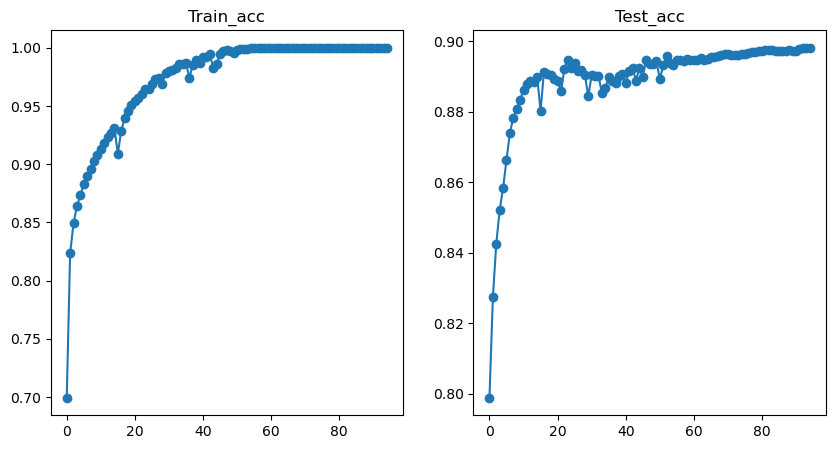

In [21]:
#lr, num_epochs = 0.5, 90
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)